# Microsoft Security Incident Prediction

This notebook provides a comprehensive workflow for predicting security incidents using a real-world dataset from Microsoft. The process includes:

1. **Data Acquisition**: Downloading part of the dataset from the Microsoft Security Incident Prediction on Kaggle. 
2. **Data Exploration**: Exploring the dataset to gain insights into its structure, identifying patterns and correlations, and assessing the distribution of key features.IncidentGrade
3. **Visualizations**: Creating various plots to visualize trends and relationships in the data, which helps in understanding the underlying patterns that could inform predictive models.
4. **Data Preprocessing**: Cleaning and preparing the dataset for training the models, including handling missing values, encoding categorical variables, and scaling numerical features.

By the end of this notebook, we will have clean, stratified, and reduced datasets ready for model training and evaluation.

Before proceeding with the download, we would like to mention that the original dataset contains two types of files: GUIDE_train and GUIDE_test. These files are large in terms of the number of rows. To carry out this project, we will use only a part of the data due to time complexity when training the models. In particular, we reduce the data to only 10,000 rows from the GUIDE_train file for training, while the GUIDE_test file will remain untouched.

Uncomment the following cell to install the required dependencies.

In [45]:
#!pip3 install -r requirements.txt # install dependencies

In [46]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from kagglehub import dataset_download
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import missingno as msno
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.manifold import LocallyLinearEmbedding
from sklearn.preprocessing import LabelEncoder


## Data Acquisition

The data acquisition process involves downloading the dataset from Kaggle. Given the large size of the dataset, which includes over 14 million individuals, we found it practical to reduce the dataset to a smaller yet representative subset. This reduction aims to significantly improve model training time, though it may slightly compromise the fidelity of the entire dataset.

We decided to work with a subset of 10,000 individuals. To ensure randomness in the selection process, we used `train_test_split` from scikit-learn. Additionally, to address potential class imbalance, we employed the `stratify` option during the splitting process. This approach helps preserve the class distribution in the reduced subset, maintaining representativeness of the original data.


In [47]:
def create_reduced_file(original_file_path, reduced_file_path, target_column, sample_size=10000):
    """
    Creates a reduced file from the original file by applying stratified undersampling.

    :param original_file_path: Path to the original file.
    :param reduced_file_path: Path where the reduced file will be saved.
    :param target_column: Name of the target column for stratification.
    :param sample_size: Size of the reduced dataset.
    """
    chunk_size = 10000  
    chunks = []
    for chunk in pd.read_csv(original_file_path, chunksize=chunk_size):
        chunks.append(chunk)
    
    df_original = pd.concat(chunks, axis=0)  
    print(f"The original file has {len(df_original)} rows.")
    
    df_original = df_original.dropna(subset=[target_column])

    df_reduced, _ = train_test_split(
        df_original,
        train_size=sample_size,
        stratify=df_original[target_column],
        random_state=42
    )
    
    df_reduced.to_csv(reduced_file_path, index=False)
    print(f"Reduced file created with {len(df_reduced)} rows, maintaining class proportions.")


We will now try to download the dataset from Kaggle or load it from the local directory if it has already been downloaded. Remembering that the file will only have 10,000 rows.

In [48]:
dataset_folder = os.getcwd()
reduced_file_path = os.path.join(dataset_folder, './data/microsoft_Reduced.csv')

try:
    if not os.path.exists(reduced_file_path):
        print("Reduced file not found. Creating a new one...")
        file_path = dataset_download("Microsoft/microsoft-security-incident-prediction")
        original_file_path = os.path.join(file_path, "GUIDE_Train.csv")
        
        create_reduced_file(original_file_path, reduced_file_path, target_column='IncidentGrade')
        
        if os.path.exists(reduced_file_path):
            print(f"Reduced file created at {reduced_file_path}")
        else:
            raise FileNotFoundError("Failed to create the reduced file.")
    else:
        print("Reduced file found. Loading...")
    
    data = pd.read_csv(reduced_file_path)
    print(f"File loaded with {len(data)} rows.")
except Exception as e:
    print(f"An error occurred: {e}")

Reduced file found. Loading...
File loaded with 10000 rows.


## Data Exploration

In this step, we aim to understand the dataset's structure, identify potential issues, and gather insights into the features. Specifically, we will:

- Preview the dataset to examine its structure and sample entries.
- Compute summary statistics to understand distributions and key metrics.
- Check for unique values in each column to identify categorical and numerical features.
- Analyze missing data to plan imputation or removal strategies.
- Inspect data types to ensure consistency and suitability for modeling.


In [49]:
data.head()

,Id,OrgId,IncidentId,AlertId,Timestamp,DetectorId,AlertTitle,Category,MitreTechniques,IncidentGrade,...,Roles,OSFamily,OSVersion,AntispamDirection,SuspicionLevel,LastVerdict,CountryCode,State,City,Usage
0,764504183844,46,2165,464218,2024-06-06T17:32:50.000Z,217,194,Execution,NaN,TruePositive,...,NaN,5,66,NaN,NaN,NaN,242,1445,10630,Public
1,335007450291,358,81220,23843,2024-06-08T19:59:54.000Z,1,1,InitialAccess,T1566.002,FalsePositive,...,NaN,5,66,NaN,NaN,NaN,242,1445,10630,Public
2,1468878815912,171,337929,433815,2024-06-13T21:39:26.000Z,862,7604,Exfiltration,NaN,BenignPositive,...,NaN,5,66,NaN,NaN,NaN,242,1445,10630,Private
3,704374638571,158,278841,1448996,2024-06-05T15:45:39.000Z,3745,22159,Exfiltration,NaN,FalsePositive,...,NaN,5,66,NaN,NaN,NaN,242,1445,10630,Public
4,523986014933,295,1723,226867,2024-06-08T23:20:44.000Z,1,1,InitialAccess,T1566.002,FalsePositive,...,NaN,5,66,NaN,NaN,Malicious,242,1445,10630,Private


In [50]:
data.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Id,10000.0,NaN,NaN,NaN,848020679316.863647,490333818947.101562,184.0,420906798236.0,841813591828.0,1271310320486.5,1709396988886.0
OrgId,10000.0,NaN,NaN,NaN,174.0017,367.429485,0.0,8.0,43.0,172.0,5951.0
IncidentId,10000.0,NaN,NaN,NaN,68409.7066,117319.419739,3.0,421.0,9179.5,82105.75,597777.0
AlertId,10000.0,NaN,NaN,NaN,408951.692,454056.606146,0.0,25326.25,227927.0,671573.0,1718911.0
Timestamp,10000,9273,2024-06-11T22:02:45.000Z,28,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DetectorId,10000.0,NaN,NaN,NaN,98.2972,415.670435,0.0,2.0,7.0,39.0,9159.0
AlertTitle,10000.0,NaN,NaN,NaN,2389.946,9948.962346,0.0,2.0,8.0,97.0,113011.0
Category,10000,17,InitialAccess,4741,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MitreTechniques,4534,186,T1078;T1078.004,1518,NaN,NaN,NaN,NaN,NaN,NaN,NaN
IncidentGrade,10000,3,BenignPositive,4226,NaN,NaN,NaN,NaN,NaN,NaN,NaN


At first glance, we notice a significant number of missing values in several attributes. We observe that the "counts" in many attributes are not 10,000, indicating the presence of missing values. In fact, some don't even reach half of 10,000, meaning the amount of missing values in certain attributes is quite substantial.

In [51]:
data.nunique()

Id                    6435
OrgId                 1061
IncidentId            6387
AlertId               9312
Timestamp             9273
DetectorId             743
AlertTitle            1863
Category                17
MitreTechniques        186
IncidentGrade            3
ActionGrouped            1
ActionGranular           2
EntityType              18
EvidenceRole             2
DeviceId               333
Sha256                 539
IpAddress             1857
Url                    631
AccountSid            2202
AccountUpn            3276
AccountObjectId       2172
AccountName           2305
DeviceName             758
NetworkMessageId      1125
EmailClusterId          87
RegistryKey             10
RegistryValueName        8
RegistryValueData        7
ApplicationId           15
ApplicationName         22
OAuthApplicationId       4
ThreatFamily            49
FileName               739
FolderPath             431
ResourceIdName           4
ResourceType             2
Roles                    6
O

In [52]:
data.isnull().sum()

Id                       0
OrgId                    0
IncidentId               0
AlertId                  0
Timestamp                0
DetectorId               0
AlertTitle               0
Category                 0
MitreTechniques       5466
IncidentGrade            0
ActionGrouped         9997
ActionGranular        9997
EntityType               0
EvidenceRole             0
DeviceId                 0
Sha256                   0
IpAddress                0
Url                      0
AccountSid               0
AccountUpn               0
AccountObjectId          0
AccountName              0
DeviceName               0
NetworkMessageId         0
EmailClusterId        9909
RegistryKey              0
RegistryValueName        0
RegistryValueData        0
ApplicationId            0
ApplicationName          0
OAuthApplicationId       0
ThreatFamily          9937
FileName                 0
FolderPath               0
ResourceIdName           0
ResourceType          9997
Roles                 9720
O

There are 10 attributes with missing values, and it's not just a small number of missings in each attribute; more than 50% are missing, with many exceeding 90%. This could hint that we may need to eliminate some variables, as imputation might not be the best option given the high proportion of missing data. 

In such cases, removing the variables with excessive missing values could be a more effective approach to avoid introducing bias or noise into the analysis.

Let's see the types of data we have in the dataset.

In [53]:
data.dtypes

Id                      int64
OrgId                   int64
IncidentId              int64
AlertId                 int64
Timestamp              object
DetectorId              int64
AlertTitle              int64
Category               object
MitreTechniques        object
IncidentGrade          object
ActionGrouped          object
ActionGranular         object
EntityType             object
EvidenceRole           object
DeviceId                int64
Sha256                  int64
IpAddress               int64
Url                     int64
AccountSid              int64
AccountUpn              int64
AccountObjectId         int64
AccountName             int64
DeviceName              int64
NetworkMessageId        int64
EmailClusterId        float64
RegistryKey             int64
RegistryValueName       int64
RegistryValueData       int64
ApplicationId           int64
ApplicationName         int64
OAuthApplicationId      int64
ThreatFamily           object
FileName                int64
FolderPath

We see a balanced proportion of categorical and numerical variables, with a slight majority of numerical ones. However, some are useless as they are unique identifiers that do not provide any valuable information.

In [54]:
df = data

## Visualizations

In this section, we will create plots of the different types of attributes to see if there are any particularities.

We will also take a look at the correlation matrix to check if there are any dependent variables.

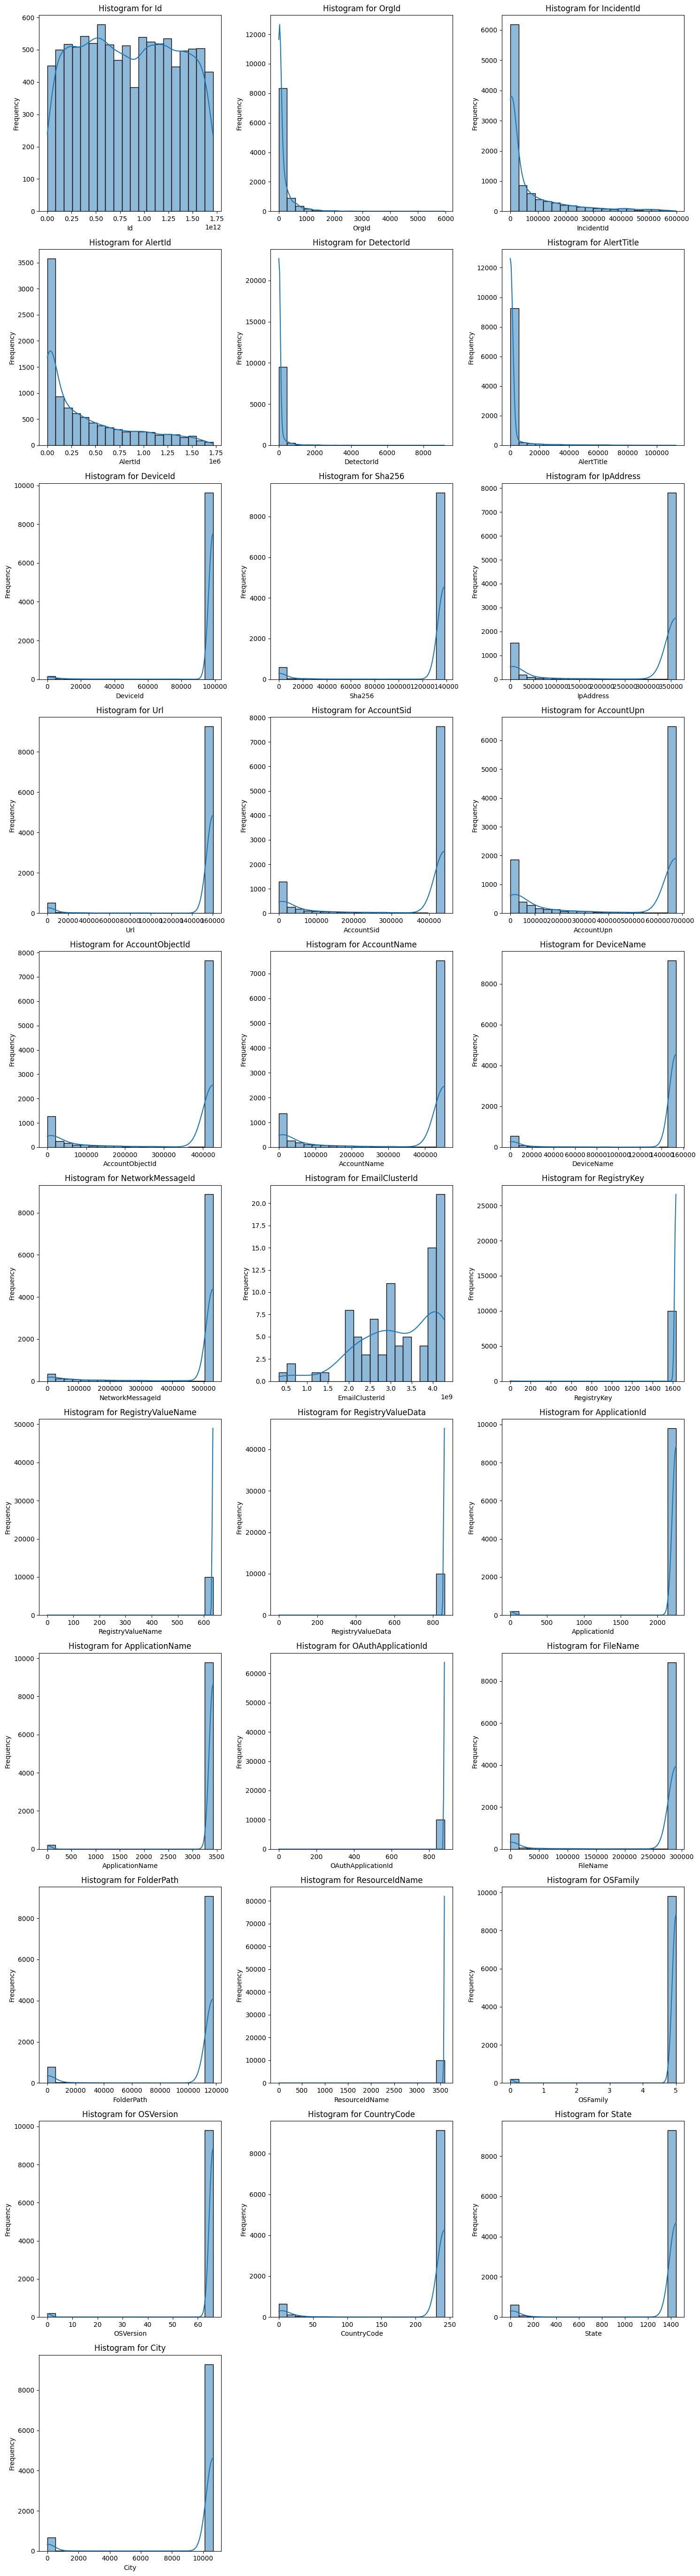

In [55]:
def plot_numerical(df):
    num_cols = df.select_dtypes(include=['int64', 'float64']).columns
    n_cols = 3  
    n_rows = int(np.ceil(len(num_cols) / n_cols))  
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
    axes = axes.flatten()  
    
    for i, col in enumerate(num_cols):
        ax = axes[i]
        sns.histplot(df[col], kde=True, bins=20, ax=ax)
        ax.set_title(f'Histogram for {col}')
        ax.set_xlabel(col)
        ax.set_ylabel('Frequency')
    
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
    
    plt.tight_layout()
    plt.show()

plot_numerical(df)


The most notable aspect of these distribution plots is the presence of numerical attributes where only a few individuals have a very low value for the attribute, while many have a high value. This could indicate the presence of extreme values or outliers.

This suggests that some form of treatment for extreme values will be necessary.

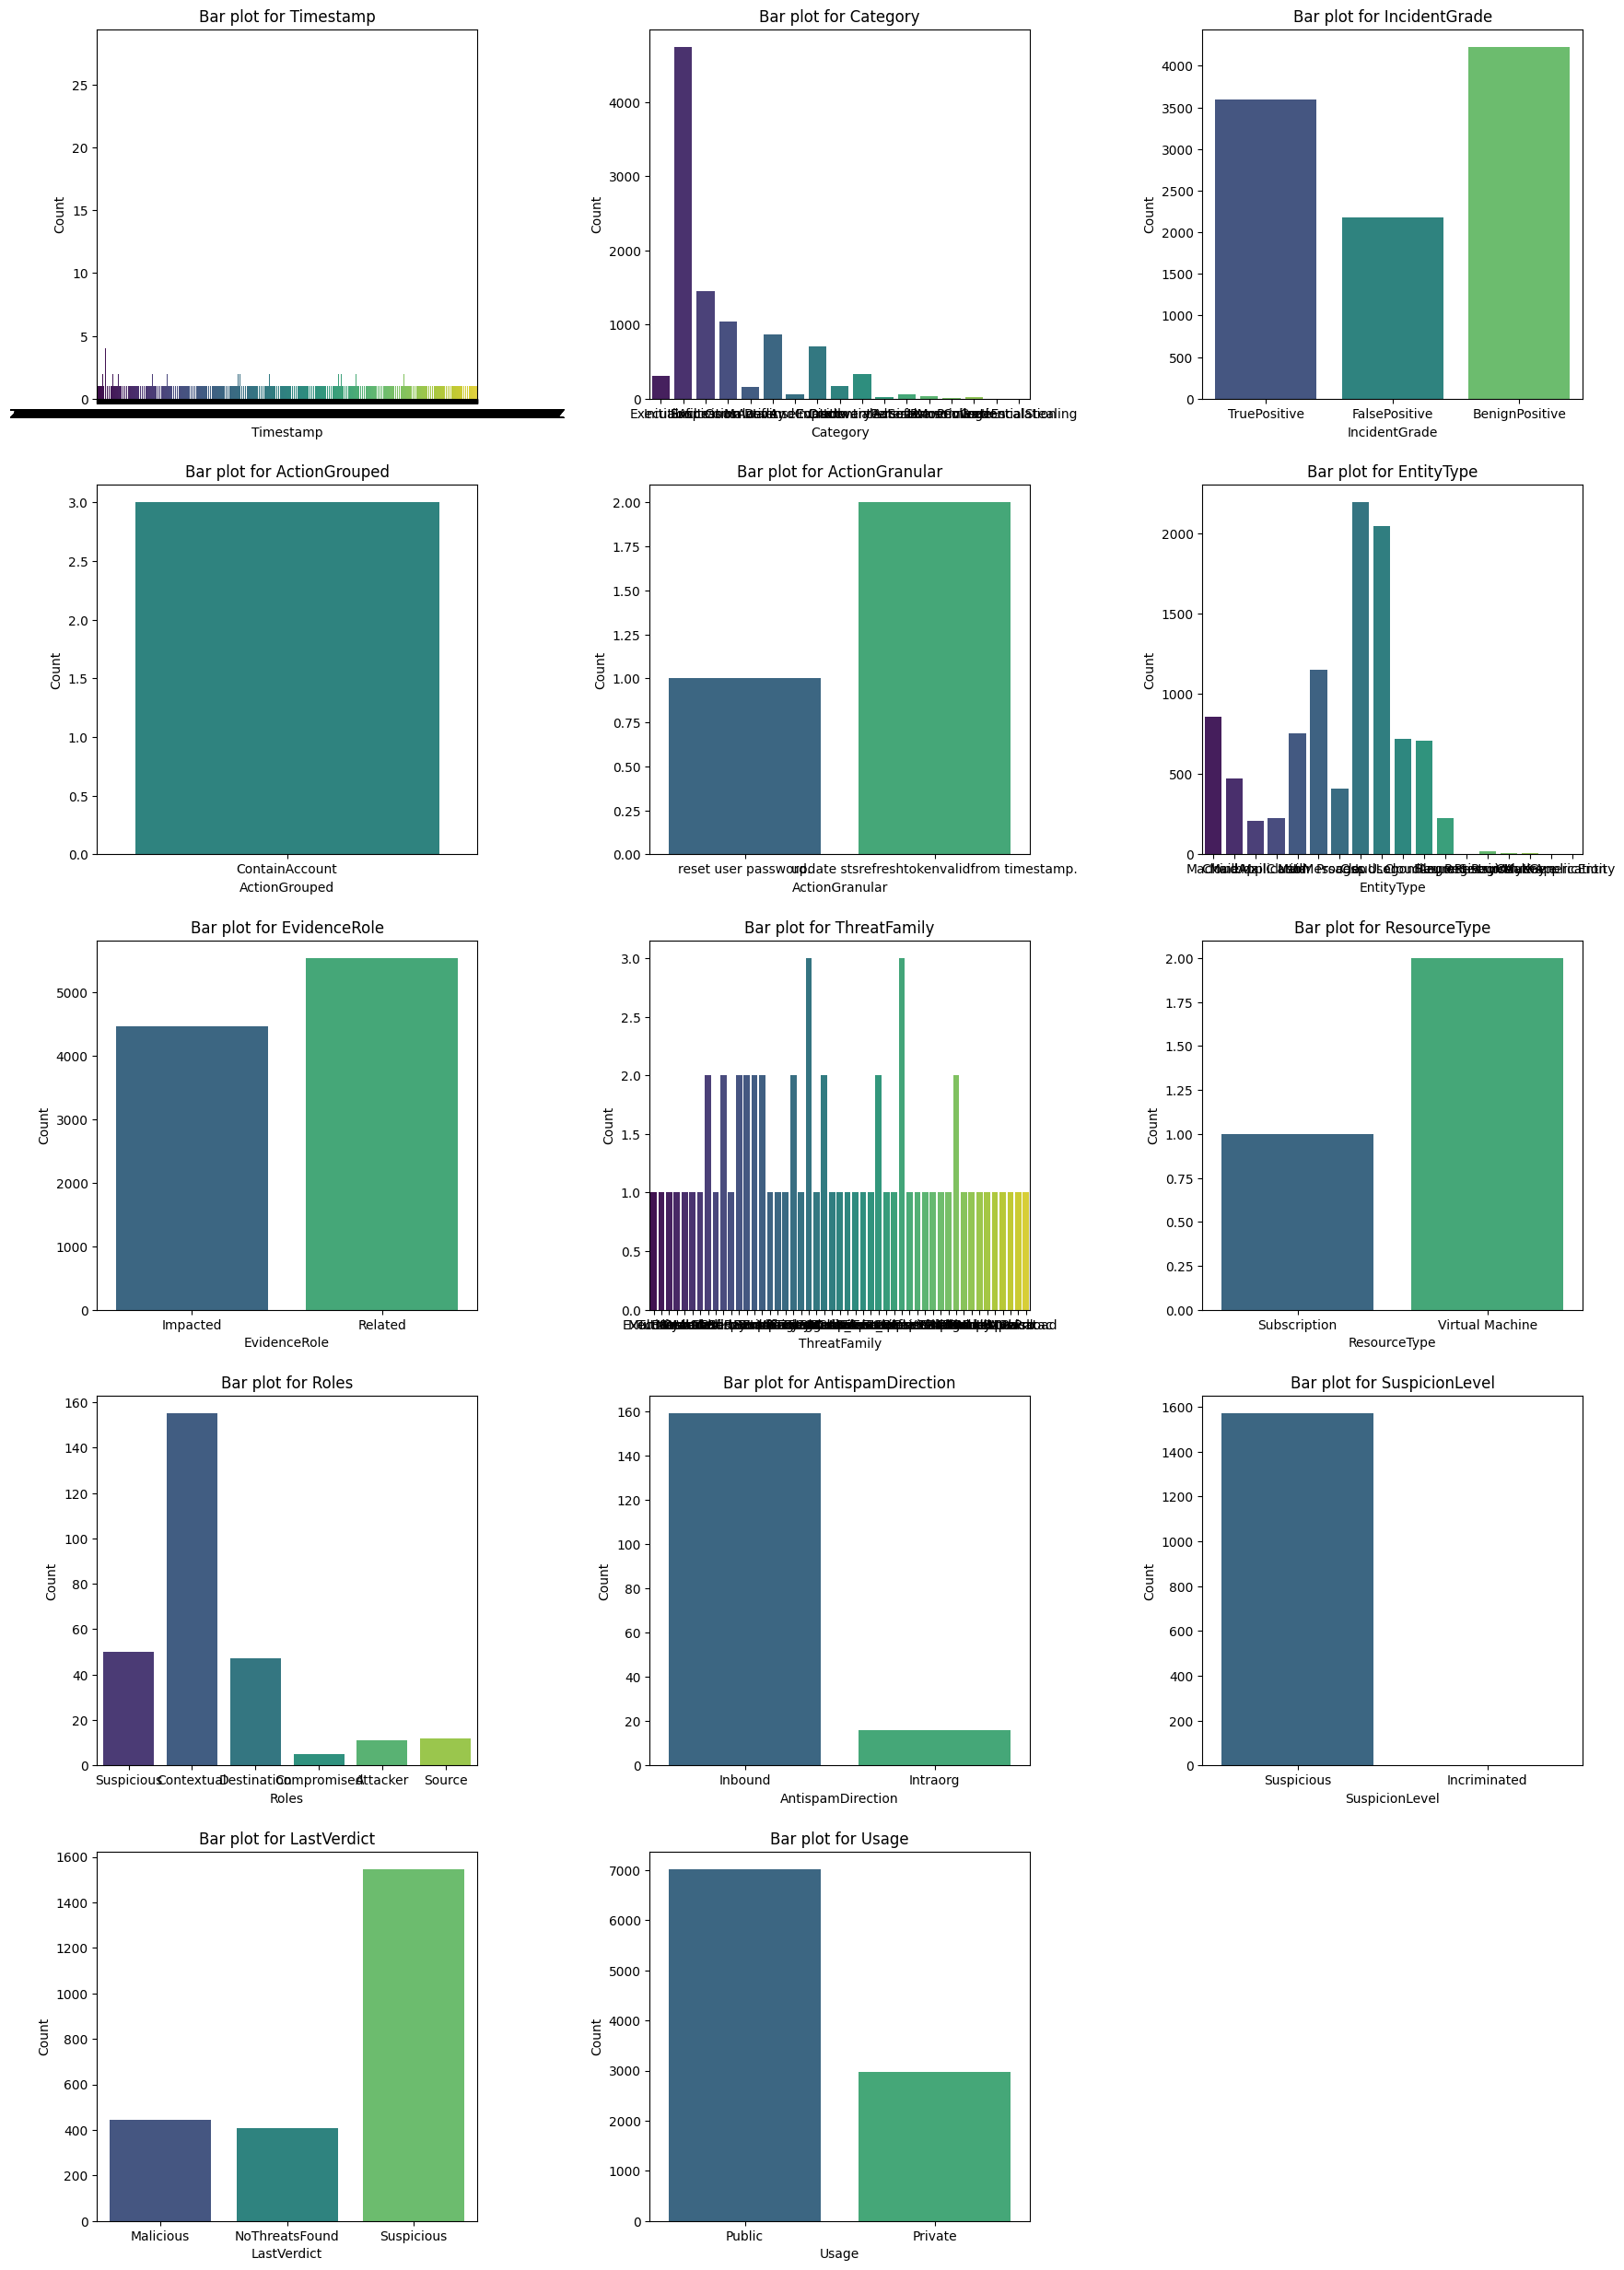

In [56]:
def plot_categorical(df):
    # Excluir la columna 'MitreTechnique' de las columnas categóricas altera todo
    cat_cols = df.select_dtypes(include=['object']).columns
    cat_cols = cat_cols[cat_cols != 'MitreTechniques']
    n_cols = 3  
    n_rows = int(np.ceil(len(cat_cols) / n_cols))  
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 5*n_rows))
    axes = axes.flatten()  
    
    for i, col in enumerate(cat_cols):
        ax = axes[i]
        sns.countplot(x=col, data=df, hue=col, palette='viridis', ax=ax, legend=False)
        ax.set_title(f'Bar plot for {col}')
        ax.set_xlabel(col)
        ax.set_ylabel('Count')
    
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
    
    plt.subplots_adjust(hspace=0.5, wspace=0.3)  
    plt.tight_layout(pad=2.0) 
    plt.show()

plot_categorical(df)


#### 'IncidentGrade'

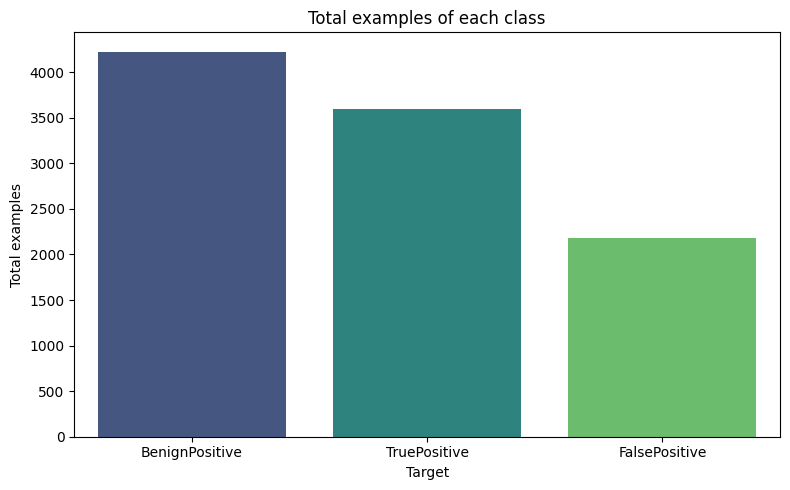

In [57]:
target_counts = df["IncidentGrade"].value_counts().reset_index()
target_counts.columns = ['target', 'count']

plt.figure(figsize=(8, 5))
sns.barplot(x='target', y='count', data=target_counts, hue='target', palette='viridis', legend=False)
plt.title('Total examples of each class')
plt.xlabel('Target')
plt.ylabel('Total examples')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

We can see that the least common incident is False Positive, while the most common is Benign Positive. And in the middle, we have True Positive, which is the most common incident. Regarding this we have some concerns that reducing the dataset to 10,000 rows may have caused some imbalance in the target variable.

#### 'Timestamp'

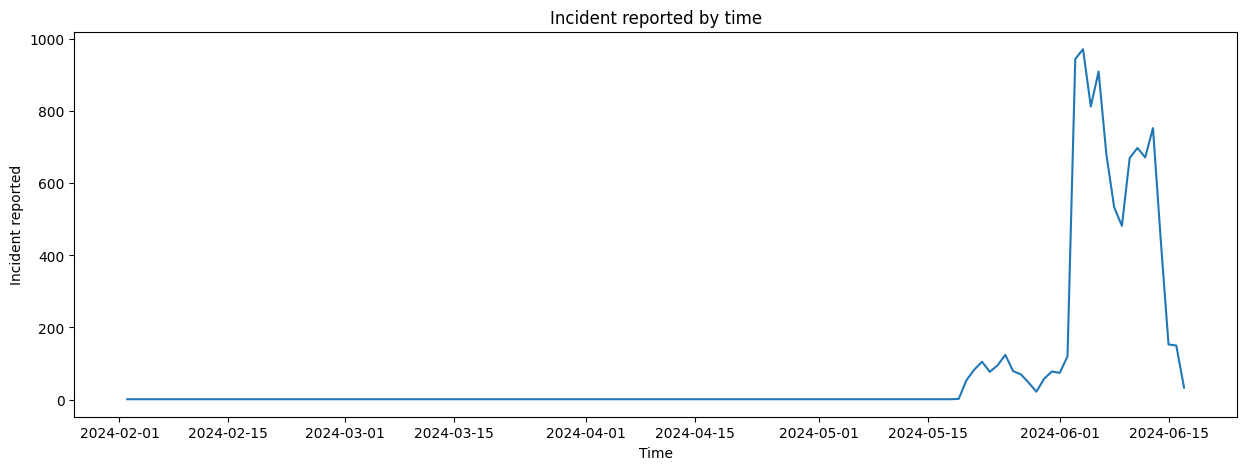

In [58]:
data['Timestamp'] = pd.to_datetime(data['Timestamp'])
incident_by_time = data.groupby(data['Timestamp'].dt.date).size()
incident_by_time.plot(figsize=(15, 5))
plt.title('Incident reported by time')
plt.xlabel('Time')
plt.ylabel('Incident reported')
plt.show()

We can observe that most incidents of the incidents are concentrated in June. This is only useful if our objective is to predict the time of the incident, which is not the case, remember that we are trying to predict the type of incident.

#### 'Category'

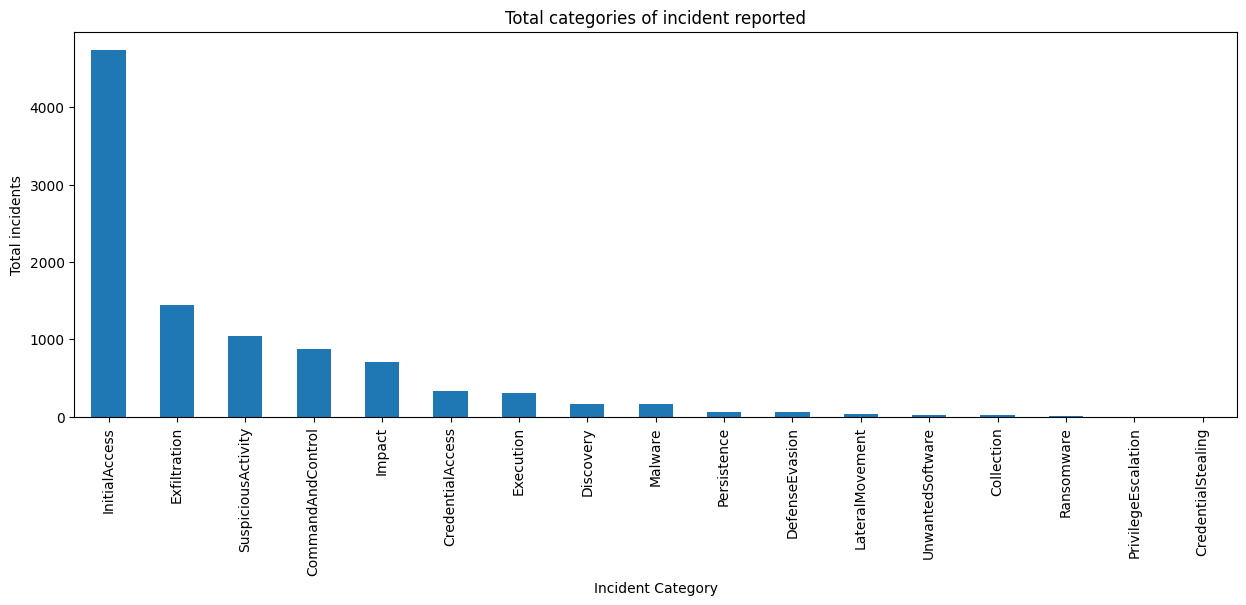

In [59]:
incident_by_category = data['Category'].value_counts()
incident_by_category.plot(kind='bar', figsize=(15, 5))
plt.title('Total categories of incident reported')
plt.xlabel('Incident Category')
plt.ylabel('Total incidents')
plt.show()


We can observe that most of the incidents are the type of 'Initial Access', followed by 'Execution' and 'SuspiciousActivity'. these last two are very close to each other. The 'initial access' type is the most common.

#### 'Threat Family'

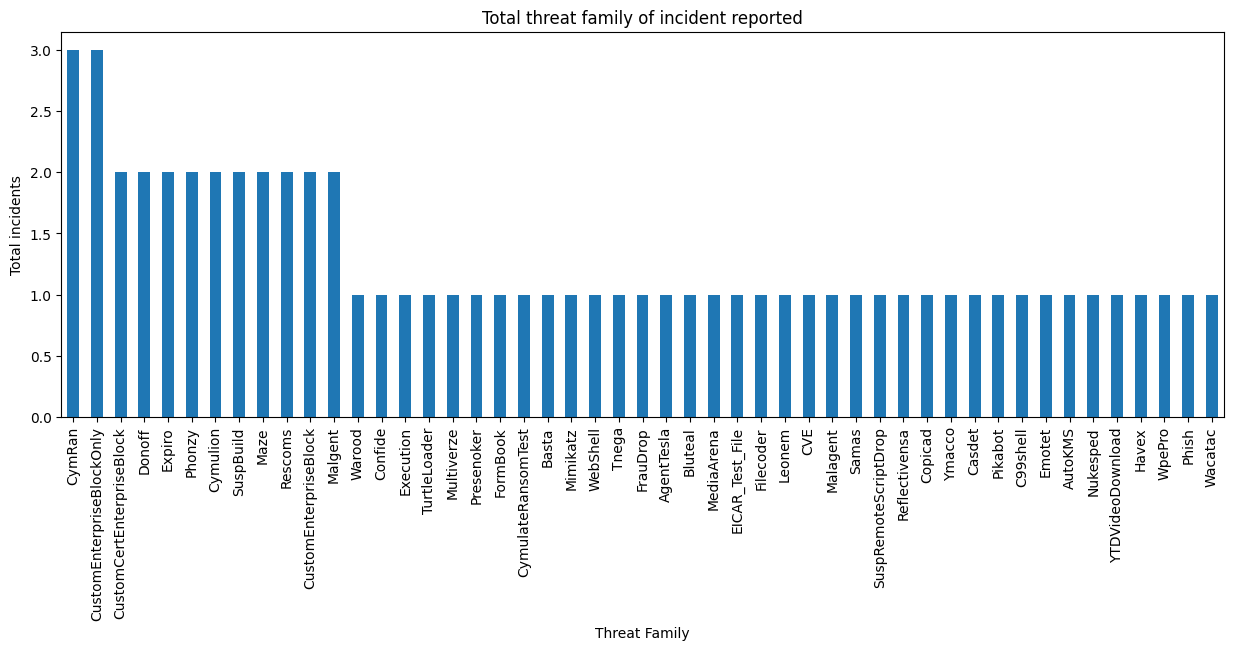

In [60]:
incident_by_category = data['ThreatFamily'].value_counts()
incident_by_category.plot(kind='bar', figsize=(15, 5))
plt.title('Total threat family of incident reported')
plt.xlabel('Threat Family')
plt.ylabel('Total incidents')
plt.show()

This plot shows the most common threat families. However  we believe that this does not add much value to the analysis, as it has mostly missing values. But we can see that the most common threat family is 'CymRan', followed by 'CustomEnterpriseBlockOnly' and 'CustomerEnterpriseBlock'.

#### 'EntityType'

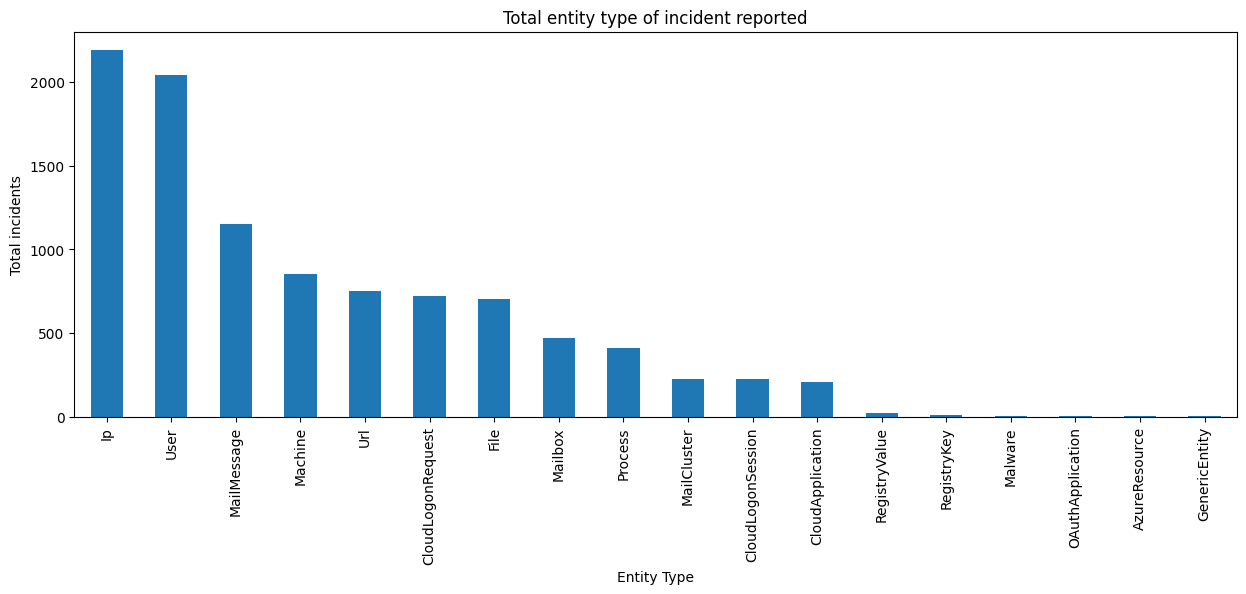

In [61]:
incident_by_category = data['EntityType'].value_counts()
incident_by_category.plot(kind='bar', figsize=(15, 5))
plt.title('Total entity type of incident reported')
plt.xlabel('Entity Type')
plt.ylabel('Total incidents')
plt.show()

The most common entity type is 'Ip', followed by 'User' and 'MailMessage'.

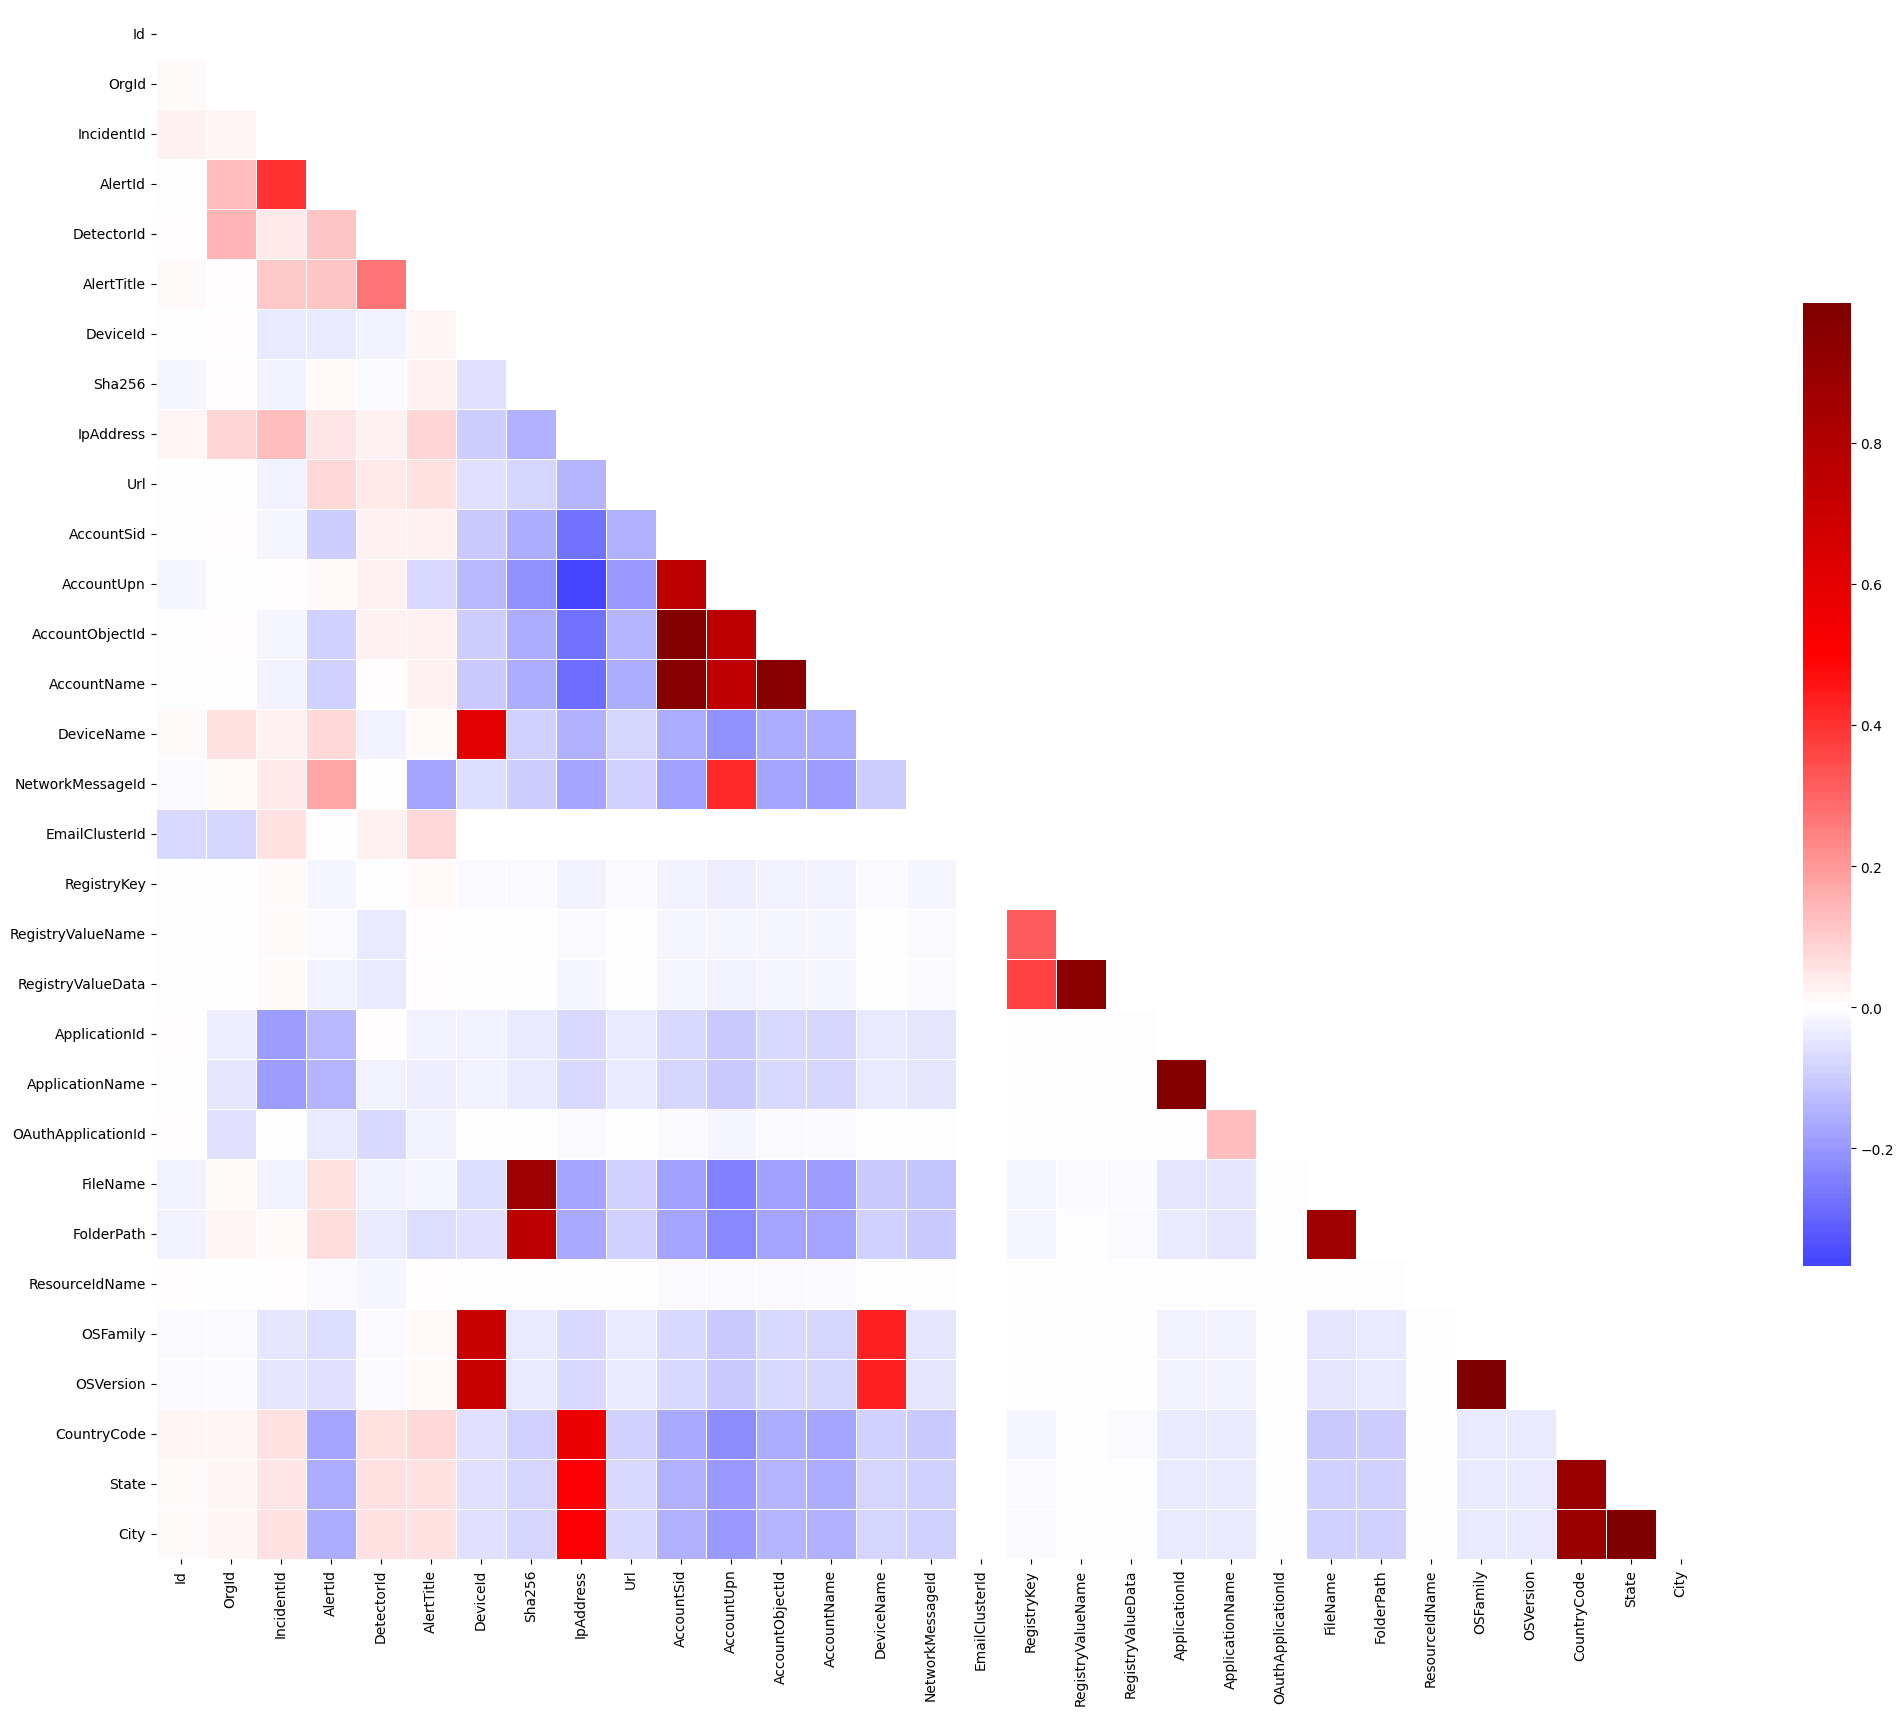

In [62]:
corr = df.corr(numeric_only=True)
mask = np.triu(np.ones_like(corr, dtype=bool))
plt.subplots(figsize=(25, 25))
sns.heatmap(corr, mask=mask, cmap='seismic',  center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5});

Regarding the correlations between variables, we observe certain white areas, indicating no relationship, and some blue zones, which suggest an inverse relationship, but we can see in the legend that it ranges between -0.2 and -0.3. We also notice some red sections, indicating a direct relationship.

We don't see the target variable in the table, as it is a categorical variable. At the end of this section, after preprocessing, we will revisit the correlation matrix and focus especially on the target variable and others.

Having seen the different aspects of the data, we can now proceed to the next step: data preprocessing.

## Splitting the Data into Training 70% and Testing Sets 30%

In [63]:
y = data['IncidentGrade']
X = data.drop(columns=['IncidentGrade','Timestamp'])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)

## Data Preprocessing

### Irrelevant features

As we have seen in the lab session, some features are not useful for the prediction for example because they are unique identifiers.

Variables with unique identifiers by description:
1. Id (Unique ID for each OrgId–IncidentId pair)
2. IncidentId (Organizationally unique incident identifier)
3. AlertId (Unique identifier for an alert)
4. DetectorId (Unique ID for the alert-generating detector)
6. DeviceId (Unique identifier for the device).
7. AccountUpn (Email account identifier).
8. EmailClusterId (Unique identifier for the email cluster)
9. NetworkMessageId (Org-level identifier for email message)
10. OAuthApplicationId (OAuth application identifier)

Based on the context of dataset let's first study the uniqueness of the features in the dataset and then decide if we should remove them or not.

In [64]:
X_train.nunique()

Id                    4675
OrgId                  922
IncidentId            4642
AlertId               6609
DetectorId             611
AlertTitle            1416
Category                17
MitreTechniques        156
ActionGrouped            1
ActionGranular           2
EntityType              18
EvidenceRole             2
DeviceId               223
Sha256                 371
IpAddress             1336
Url                    476
AccountSid            1566
AccountUpn            2358
AccountObjectId       1544
AccountName           1644
DeviceName             537
NetworkMessageId       817
EmailClusterId          65
RegistryKey              9
RegistryValueName        6
RegistryValueData        5
ApplicationId           14
ApplicationName         17
OAuthApplicationId       2
ThreatFamily            37
FileName               507
FolderPath             309
ResourceIdName           4
ResourceType             2
Roles                    6
OSFamily                 3
OSVersion                6
A

First, we can say that the feature AlertId is almost unique in all the datasets, so we can drop it. Also in the context of the project, the Id column is not useful for the model, so we can drop it, too. On the other hand, based on the context of having different variables, we think that OAuthApplicationId, AccountObjectSid, and DeviceId are not useful for the model, so we can drop them, too. For the last features, see the section in the report. 

In [65]:
variablesWithUniqueId = ['OAuthApplicationId', 'DeviceId','AccountSid', 'Id','AlertId']

In [66]:
X_train.drop(columns=variablesWithUniqueId, inplace=True)

In [67]:
X_train.columns

Index(['OrgId', 'IncidentId', 'DetectorId', 'AlertTitle', 'Category',
       'MitreTechniques', 'ActionGrouped', 'ActionGranular', 'EntityType',
       'EvidenceRole', 'Sha256', 'IpAddress', 'Url', 'AccountUpn',
       'AccountObjectId', 'AccountName', 'DeviceName', 'NetworkMessageId',
       'EmailClusterId', 'RegistryKey', 'RegistryValueName',
       'RegistryValueData', 'ApplicationId', 'ApplicationName', 'ThreatFamily',
       'FileName', 'FolderPath', 'ResourceIdName', 'ResourceType', 'Roles',
       'OSFamily', 'OSVersion', 'AntispamDirection', 'SuspicionLevel',
       'LastVerdict', 'CountryCode', 'State', 'City', 'Usage'],
      dtype='object')

Let's now explore the null values.

### Handling Missing Values

In [68]:
columns_with_missing = X_train.columns[X_train.isnull().any()]

for column in columns_with_missing:
    num_missing = X_train[column].isnull().sum()
    print(f"{column}: {X_train[column].dtype}, Missing values = {num_missing}")

MitreTechniques: object, Missing values = 3791
ActionGrouped: object, Missing values = 6998
ActionGranular: object, Missing values = 6998
EmailClusterId: float64, Missing values = 6931
ThreatFamily: object, Missing values = 6958
ResourceType: object, Missing values = 6997
Roles: object, Missing values = 6799
AntispamDirection: object, Missing values = 6864
SuspicionLevel: object, Missing values = 5898
LastVerdict: object, Missing values = 5304


As we can see, they are all categorical.

Let's analize if we can do imputation over the missing values for each features where are missing

#### Simple Methodology for Handling Missing Values:

1. **Remove of columns with missing values > 50%**:
   - If a column has more than 50% missing values, we have decided to remove it, we also consider the previsualization and display of numbers of that column in Kaggle. This is simple and prevents the complexity of imputing values.

2. **Imputation with the mode or mean**:
   - For columns with a small number of missing values, the simplest approach is to replace the missing values with the mode (for categorical variables) or the mean (for numerical variables). This ensures that data is not lost while keeping things simple.

This methodology is effective in many cases and avoids complexity, although it may not be ideal for all situations, especially when missing data is not missing at random.


Before removing, let's analyze if there is a pattern between the two features with missing values.

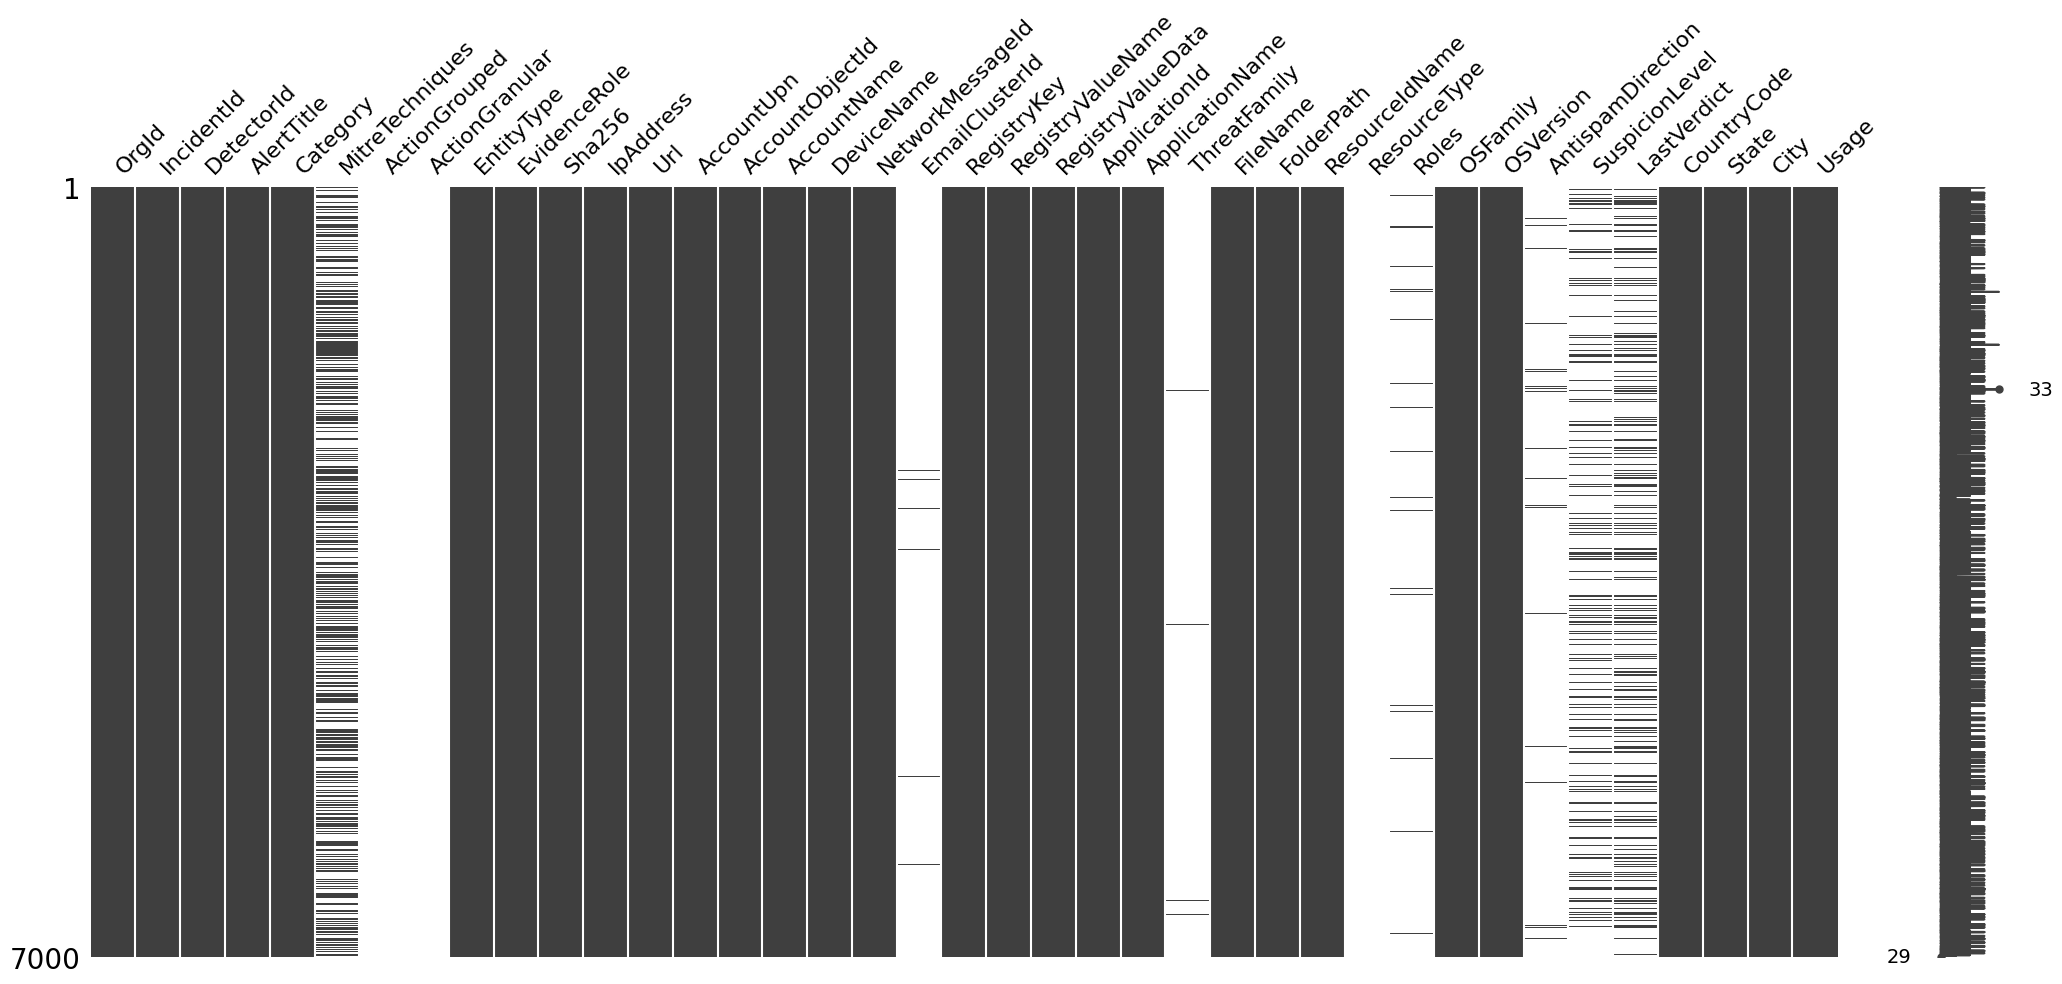

In [69]:
msno.matrix(X_train);

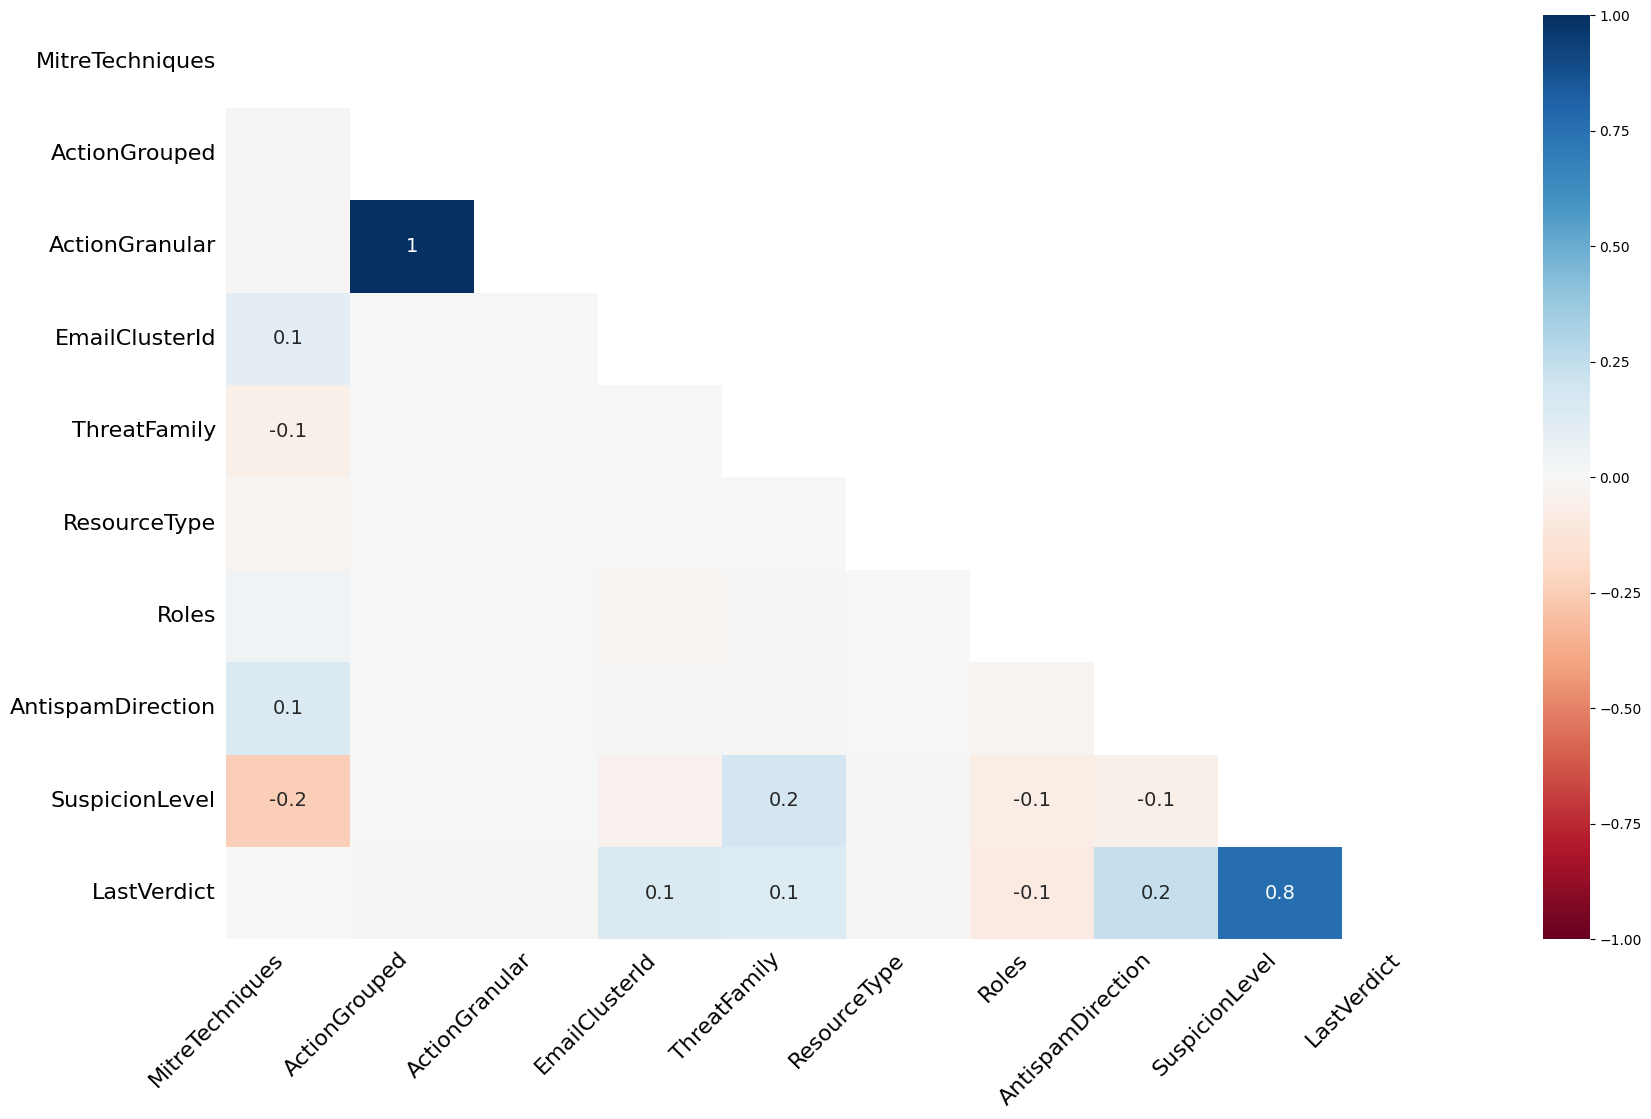

In [70]:
msno.heatmap(X_train);

Disregarding the one-to-one relationship between ActionGrouped and ActionGranular (as it doesn't provide useful information), 

We can observe that "LastVerdict" is correlated with "SuspicionLevel." Because of that both columns have aproximately the same number of missing values, we cannot imputeti missing values because both have more than 50% of missing values. So we will remove them.

#### Removing features
Now we are going to proceed to remove those features that has more then 50% of missing values.

In [71]:
missing_percentages = X_train.isnull().mean() * 100
columns_to_drop = missing_percentages[missing_percentages > 50].index
print("Columns with more than 50% missing values:")
for column in columns_to_drop:
    print(f"{column}: {missing_percentages[column]:.2f}% missing")
X_train = X_train.drop(columns=columns_to_drop)
print(f"\nNumber of columns removed: {len(columns_to_drop)}")


Columns with more than 50% missing values:
MitreTechniques: 54.16% missing
ActionGrouped: 99.97% missing
ActionGranular: 99.97% missing
EmailClusterId: 99.01% missing
ThreatFamily: 99.40% missing
ResourceType: 99.96% missing
Roles: 97.13% missing
AntispamDirection: 98.06% missing
SuspicionLevel: 84.26% missing
LastVerdict: 75.77% missing

Number of columns removed: 10


In [72]:
X_train.isnull().sum()

OrgId                0
IncidentId           0
DetectorId           0
AlertTitle           0
Category             0
EntityType           0
EvidenceRole         0
Sha256               0
IpAddress            0
Url                  0
AccountUpn           0
AccountObjectId      0
AccountName          0
DeviceName           0
NetworkMessageId     0
RegistryKey          0
RegistryValueName    0
RegistryValueData    0
ApplicationId        0
ApplicationName      0
FileName             0
FolderPath           0
ResourceIdName       0
OSFamily             0
OSVersion            0
CountryCode          0
State                0
City                 0
Usage                0
dtype: int64

Now that we have cleaned the data, we can proceed with the feature engineering. We will start by encoding the categorical columns.

### Transforming Categorical Values

In [73]:
categorical_columns = X_train.select_dtypes(include=['object']).columns
print(f"Categorical columns: {categorical_columns}")

Categorical columns: Index(['Category', 'EntityType', 'EvidenceRole', 'Usage'], dtype='object')


In [74]:
print(X_train.shape)
df_encoded = pd.get_dummies(X_train, drop_first=True)
df_encoded.shape

(7000, 29)


(7000, 60)

### One-Hot Encoding

One-Hot Encoding can drastically increase the number of features in the dataset. In this case, applying it to categorical columns with many unique values causes the dataset to expand from 29 columns to 60. This can lead to **increased dimensionality**; a massive increase in columns can cause higher computational cost, longer training times, and make models harder to interpret. In this case the number of columns is not so high, but we can consider this as a disadvantage and we can use another method to encode the categorical variables.

As an alternative, **Label Encoding** is more efficient, reducing the dimensionality while still transforming categorical variables into numeric values.


In [75]:
categorical_cols = X_train.select_dtypes(include=['object']).columns

label_encoder = LabelEncoder()

for col in categorical_cols:
    X_train[col] = label_encoder.fit_transform(X_train[col])

X_train.shape

(7000, 29)

This visualization shows that the column MitreTechniques has a low correlation with the objective variable. Additionally, more than 50% of its values are missing. Based on these observations, we decided to remove this column as it is unlikely to provide significant value to the predictive model

In [76]:
X_train.dtypes

OrgId                int64
IncidentId           int64
DetectorId           int64
AlertTitle           int64
Category             int64
EntityType           int64
EvidenceRole         int64
Sha256               int64
IpAddress            int64
Url                  int64
AccountUpn           int64
AccountObjectId      int64
AccountName          int64
DeviceName           int64
NetworkMessageId     int64
RegistryKey          int64
RegistryValueName    int64
RegistryValueData    int64
ApplicationId        int64
ApplicationName      int64
FileName             int64
FolderPath           int64
ResourceIdName       int64
OSFamily             int64
OSVersion            int64
CountryCode          int64
State                int64
City                 int64
Usage                int64
dtype: object

### Extreme Values

Upon analyzing the distribution of some numerical and categorical features in the dataset (hosted on Kaggle), we identified several columns with extreme or outlier values. These features include:

1. **ApplicationName**  
2. **FileName**  
3. **FolderPath**  
4. **OSFamily**  
5. **OSVersion**  
6. **CountryCode**  
7. **State**  
8. **City**  
9. **DeviceName**  
10. **AccountName**  
11. **AccountSID**  
12. **URL**  
13. **IPAddress**  
14. **SHA256**

These extreme values may represent rare or exceptional cases that could skew the analysis or model training. We plan to investigate these columns further to determine how to handle these outliers appropriately—whether by normalization, transformation, or removal—depending on their relevance and impact on the model.

In [77]:
columns = [
    "ApplicationName", "FileName", "FolderPath", "OSFamily", "OSVersion", 
    "CountryCode", "State", "City", "DeviceName", "AccountName", 
    "AccountSID", "URL", "IPAddress", "SHA256"
]

outliers_info = {}

for col in columns:
    if col in X_train.select_dtypes(include=['number']).columns: 
        Q1 = X_train[col].quantile(0.25)
        Q3 = X_train[col].quantile(0.75)
        IQR = Q3 - Q1

        small_outliers = X_train[col] < (Q1 - 1.5 * IQR)
        big_outliers = X_train[col] > (Q3 + 1.5 * IQR)

        outliers_info[col] = {
            "Q1": Q1,
            "Q3": Q3,
            "IQR": IQR,
            "small_outliers": sum(small_outliers),
            "big_outliers": sum(big_outliers),
            "outlier_values": X_train[col][small_outliers | big_outliers].head().tolist()
        }

outliers_info


{'ApplicationName': {'Q1': 3421.0,
  'Q3': 3421.0,
  'IQR': 0.0,
  'small_outliers': 146,
  'big_outliers': 0,
  'outlier_values': [4, 3, 4, 22, 4]},
 'FileName': {'Q1': 289573.0,
  'Q3': 289573.0,
  'IQR': 0.0,
  'small_outliers': 748,
  'big_outliers': 0,
  'outlier_values': [65, 2183, 148993, 48633, 3283]},
 'FolderPath': {'Q1': 117668.0,
  'Q3': 117668.0,
  'IQR': 0.0,
  'small_outliers': 629,
  'big_outliers': 0,
  'outlier_values': [62, 0, 0, 2, 1]},
 'OSFamily': {'Q1': 5.0,
  'Q3': 5.0,
  'IQR': 0.0,
  'small_outliers': 136,
  'big_outliers': 0,
  'outlier_values': [0, 0, 0, 0, 0]},
 'OSVersion': {'Q1': 66.0,
  'Q3': 66.0,
  'IQR': 0.0,
  'small_outliers': 136,
  'big_outliers': 0,
  'outlier_values': [0, 0, 0, 0, 0]},
 'CountryCode': {'Q1': 242.0,
  'Q3': 242.0,
  'IQR': 0.0,
  'small_outliers': 588,
  'big_outliers': 0,
  'outlier_values': [5, 7, 22, 1, 3]},
 'State': {'Q1': 1445.0,
  'Q3': 1445.0,
  'IQR': 0.0,
  'small_outliers': 485,
  'big_outliers': 0,
  'outlier_values':

### Normalization

In [78]:
scaler = MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns,index=X_train.index)

### PCA

Text(0.5, 1.0, 'Percentage of Variance Explained by Component')

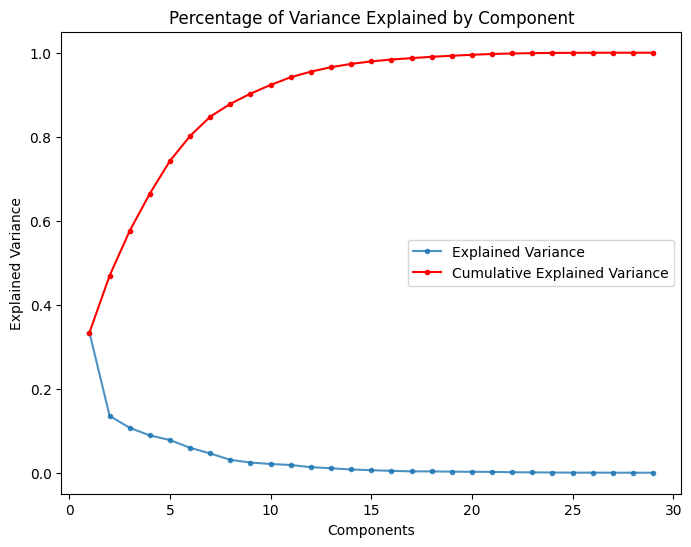

In [79]:
pca = PCA().fit(X_train_scaled)
fig = plt.figure(figsize=(8,6))
plt.plot(range(1,len(pca.explained_variance_ratio_ )+1), pca.explained_variance_ratio_, alpha=0.8, marker='.', label="Explained Variance")
y_label = plt.ylabel('Explained Variance')
x_label = plt.xlabel('Components')
plt.plot(range(1,len(pca.explained_variance_ratio_ )+1),
         np.cumsum(pca.explained_variance_ratio_),
         c='red', marker='.',
         label="Cumulative Explained Variance")
plt.legend()
plt.title('Percentage of Variance Explained by Component')

We can observe that the first 10 components explain more than 80% of the variance in the data. But the first 5 compononents aproximately explain 60% of the variance. Let's see and try to visualize the data in 2D.

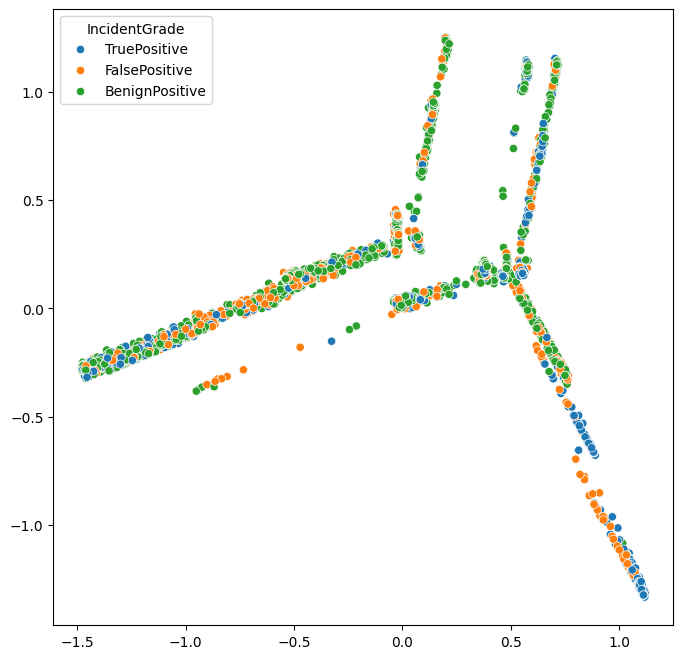

In [80]:
X_trans = pca.transform(X_train_scaled)
plt.figure(figsize=(8,8));
sns.scatterplot(x=X_trans[:,0], y=X_trans[:,1], hue=y_train);

### t-SNE

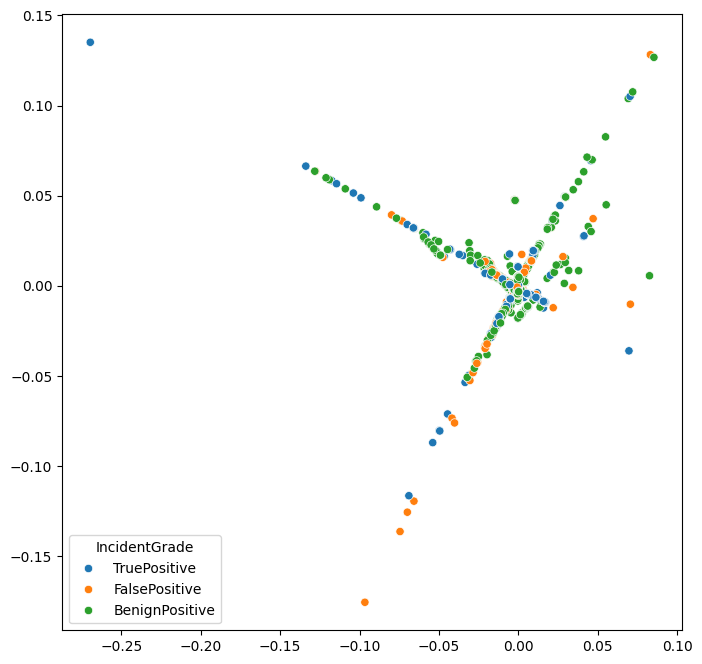

In [81]:
lle = LocallyLinearEmbedding(n_components=2, n_neighbors=17)
X_trans = lle.fit_transform(X_train_scaled)

fig = plt.figure(figsize=(8,8))
sns.scatterplot(x=X_trans[:,0], y=X_trans[:,1], hue=y_train);

We can observe that the data seems to be not linearly separable, so this give us a hint that non-linear models might perform better.

### Preprocessing on the X_test

To ensure consistency, we will apply the same preprocessing steps used on `X_train` to `X_test`. This includes:

1. **Handling Missing Values**:
   - Imputation or removal based on the decisions and parameters from `X_train`.

2. **Outlier Detection**:
   - Using the IQR thresholds calculated from `X_train` to identify and handle outliers in `X_test`.

3. **Feature Transformations**:
   - Applying the same scaling, encoding, and transformations as in `X_train`.

4. **Column Removal**:
   - Dropping columns removed in `X_train` to maintain uniformity.

This ensures consistent data preparation for model evaluation.


In [82]:
X_test.drop(columns=variablesWithUniqueId, inplace=True)

In [83]:
columns_with_missing = X_test.columns[X_test.isnull().any()]

for column in columns_with_missing:
    num_missing = X_test[column].isnull().sum()
    print(f"{column}: {X_test[column].dtype}, Missing values = {num_missing}")

MitreTechniques: object, Missing values = 1675
ActionGrouped: object, Missing values = 2999
ActionGranular: object, Missing values = 2999
EmailClusterId: float64, Missing values = 2978
ThreatFamily: object, Missing values = 2979
ResourceType: object, Missing values = 3000
Roles: object, Missing values = 2921
AntispamDirection: object, Missing values = 2961
SuspicionLevel: object, Missing values = 2531
LastVerdict: object, Missing values = 2298


In [84]:
missing_percentages = X_test.isnull().mean() * 100
columns_to_drop = missing_percentages[missing_percentages > 50].index
print("Columns with more than 50% missing values:")
for column in columns_to_drop:
    print(f"{column}: {missing_percentages[column]:.2f}% missing")
X_test = X_test.drop(columns=columns_to_drop)
print(f"\nNumber of columns removed: {len(columns_to_drop)}")


Columns with more than 50% missing values:
MitreTechniques: 55.83% missing
ActionGrouped: 99.97% missing
ActionGranular: 99.97% missing
EmailClusterId: 99.27% missing
ThreatFamily: 99.30% missing
ResourceType: 100.00% missing
Roles: 97.37% missing
AntispamDirection: 98.70% missing
SuspicionLevel: 84.37% missing
LastVerdict: 76.60% missing

Number of columns removed: 10


In [85]:

categorical_cols = X_test.select_dtypes(include=['object']).columns

label_encoder = LabelEncoder()

for col in categorical_cols:
    X_test[col] = label_encoder.fit_transform(X_test[col])

X_test.shape

(3000, 29)

In [86]:
columns = [
    "ApplicationName", "FileName", "FolderPath", "OSFamily", "OSVersion", 
    "CountryCode", "State", "City", "DeviceName", "AccountName", 
    "AccountSID", "URL", "IPAddress", "SHA256"
]

outliers_info = {}

for col in columns:
    if col in X_test.select_dtypes(include=['number']).columns: 
        Q1 = X_test[col].quantile(0.25)
        Q3 = X_test[col].quantile(0.75)
        IQR = Q3 - Q1

        small_outliers = X_test[col] < (Q1 - 1.5 * IQR)
        big_outliers = X_test[col] > (Q3 + 1.5 * IQR)

        outliers_info[col] = {
            "Q1": Q1,
            "Q3": Q3,
            "IQR": IQR,
            "small_outliers": sum(small_outliers),
            "big_outliers": sum(big_outliers),
            "outlier_values": X_test[col][small_outliers | big_outliers].head().tolist()
        }

outliers_info


{'ApplicationName': {'Q1': 3421.0,
  'Q3': 3421.0,
  'IQR': 0.0,
  'small_outliers': 64,
  'big_outliers': 0,
  'outlier_values': [0, 0, 0, 0, 6]},
 'FileName': {'Q1': 289573.0,
  'Q3': 289573.0,
  'IQR': 0.0,
  'small_outliers': 365,
  'big_outliers': 0,
  'outlier_values': [388, 88242, 555, 211581, 3]},
 'FolderPath': {'Q1': 117668.0,
  'Q3': 117668.0,
  'IQR': 0.0,
  'small_outliers': 309,
  'big_outliers': 0,
  'outlier_values': [98404, 58389, 1110, 0, 6]},
 'OSFamily': {'Q1': 5.0,
  'Q3': 5.0,
  'IQR': 0.0,
  'small_outliers': 65,
  'big_outliers': 0,
  'outlier_values': [0, 0, 0, 0, 0]},
 'OSVersion': {'Q1': 66.0,
  'Q3': 66.0,
  'IQR': 0.0,
  'small_outliers': 65,
  'big_outliers': 0,
  'outlier_values': [0, 0, 0, 0, 0]},
 'CountryCode': {'Q1': 242.0,
  'Q3': 242.0,
  'IQR': 0.0,
  'small_outliers': 275,
  'big_outliers': 0,
  'outlier_values': [1, 0, 0, 1, 3]},
 'State': {'Q1': 1445.0,
  'Q3': 1445.0,
  'IQR': 0.0,
  'small_outliers': 226,
  'big_outliers': 0,
  'outlier_values

In [87]:
scaler = MinMaxScaler()

X_test_scaled = scaler.fit_transform(X_test)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns,index=X_test.index)

Since we have decided to have two notebooks, one for the preparation of the data and another for the training of the models, we will save the data in a csv file to be used in the next notebook.

## Saving Data for The Model Evaluation

In [88]:
import os

folder_path = './data'

try:
    os.makedirs(folder_path, exist_ok=True)

    X_train_scaled.to_csv(os.path.join(folder_path, 'X_train.csv'), index=False)
    X_test_scaled.to_csv(os.path.join(folder_path, 'X_test.csv'), index=False)
    y_train.to_csv(os.path.join(folder_path, 'y_train.csv'), index=False)
    y_test.to_csv(os.path.join(folder_path, 'y_test.csv'), index=False)

    print("Files saved successfully!")

except Exception as e:
    print(f"An unexpected error occurred: {e}")


Files saved successfully!


We will analyze the correlations of the attributes after preprocessing. Now that they are all numeric, we will be able to view them all.


<Axes: >

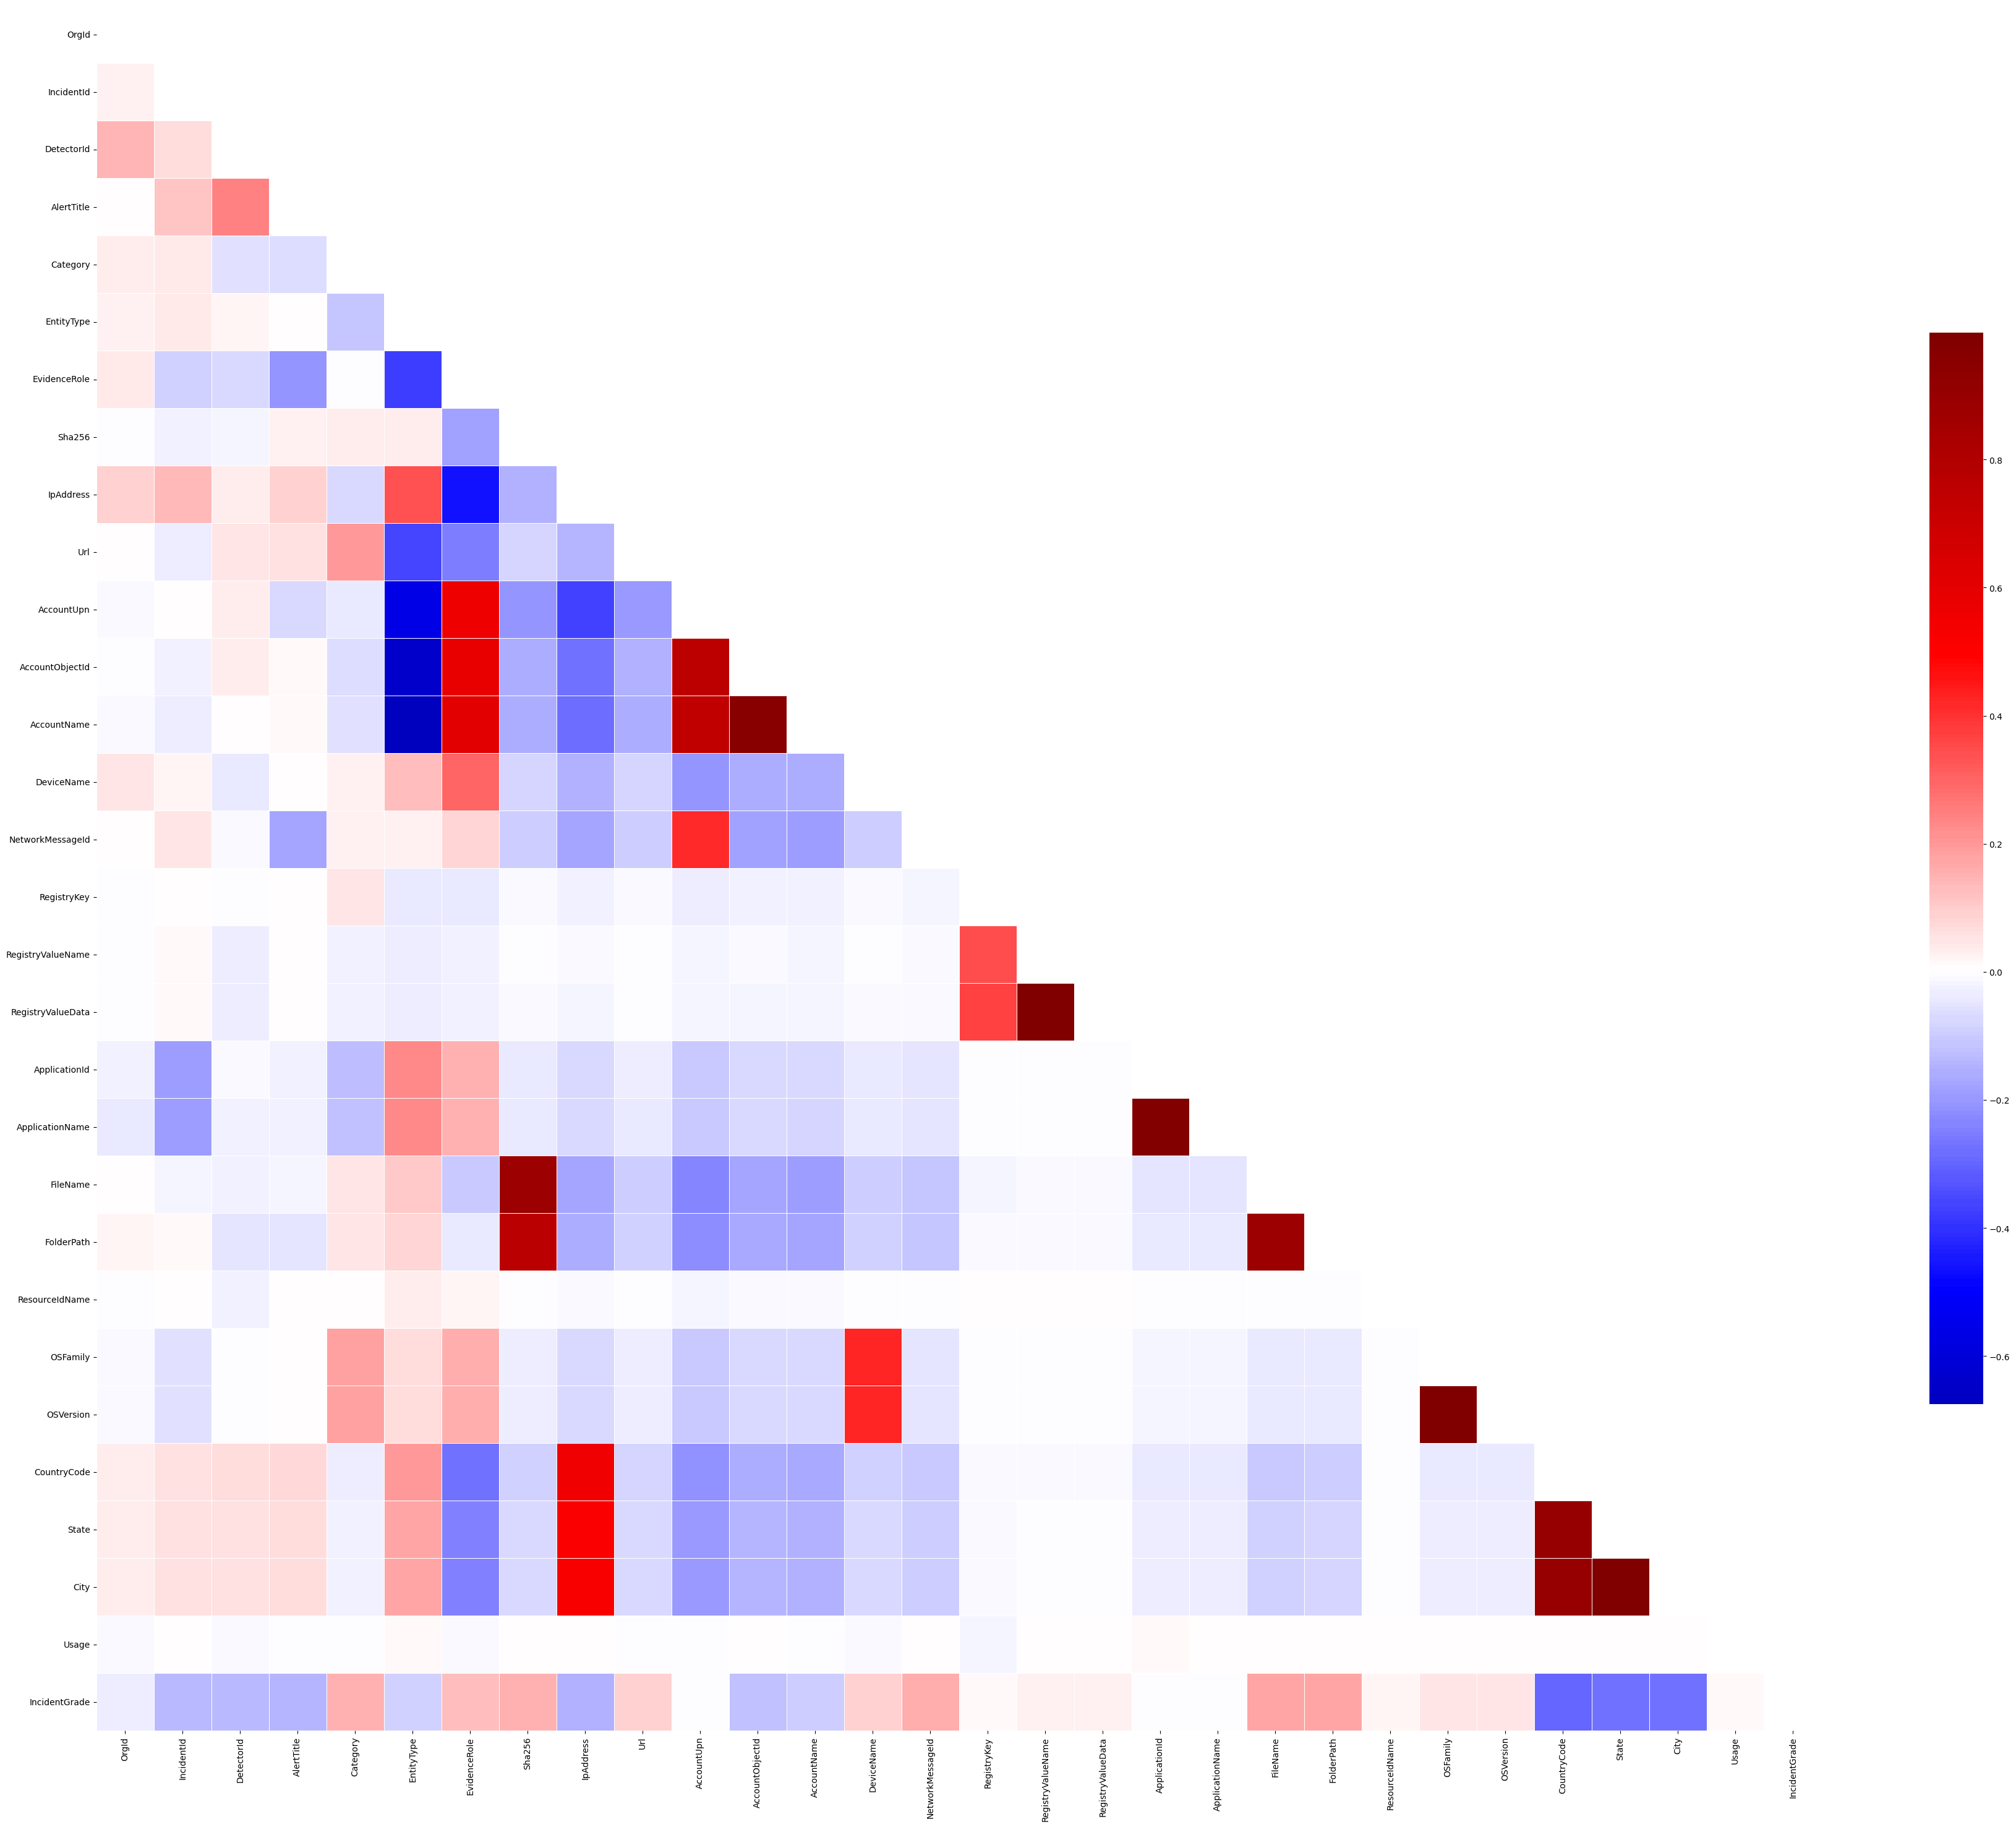

In [89]:
data_new = pd.concat([X_train_scaled, y_train], axis=1)
label_encoder = LabelEncoder()

for column in data_new.select_dtypes(include=['object']).columns:
    data_new[column] = label_encoder.fit_transform(data_new[column])

corr = data_new.corr()

mask = np.triu(np.ones_like(corr, dtype=bool))

plt.subplots(figsize=(45, 45))
sns.heatmap(corr, mask=mask, cmap='seismic', center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})


We observe that the target variable (IncidentGrade) shows some inverse correlation with location-related attributes (Country, State, City), which could suggest that the location-related attributes might play a role in reducing the severity of incidents, possibly due to regional differences in attack patterns or defense mechanisms.

It also shows a positive correlation with attributes such as SHA256, FileName, and FolderPath, which may indicate that certain types of files or their paths are associated with more severe incidents, potentially pointing to specific attack methods or file-related exploits that contribute to the incident's severity.